# Imports and env variables

In [ ]:
!pip install -q -U albumentations

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import mixed_precision
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from functools import partial
from albumentations import (
    Compose, RandomBrightnessContrast, ImageCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate, Affine, Perspective, Blur
)
import zipfile

In [3]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# (Optional) Google Drive unzipping

In [ ]:
path_to_zip_file = 'drive/MyDrive/split_ocean_v2.zip'
directory_to_extract_to = '.'

In [ ]:
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Config

In [1]:
train_dir = "../ocean_elements_v5/ocean_elements/"  # Entrenamiento con todo el dataset
# Esta validación no tiene valor ya que en el train se incluyen estas imágenes para la entrega
val_dir = "../split_ocean_elements/val/"
BATCH_SIZE = 4

# Entrenamiento

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

Se definen los DataLoaders para leer imágenes y etiquetas

In [5]:
# classes for data loading
class Dataset:
    """Oceans Dataset. Reads images and applies augmentation.
    
    Args:
        images_dir (str): path to images folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
    """
    
    def __init__(
            self, 
            images_dir,
            augmentation=None, 
    ):
        # list of classes
        self.CLASSES = ['algas', 'basura', 'fauna', 'ripples', 'roca']
        # get list with all the images
        all_images = []
        for class_ in self.CLASSES:
            image_ids = os.listdir(os.path.join(images_dir, class_))
            images = [os.path.join(class_, image_id) for image_id in image_ids]
            all_images += images
        # self.ids are similar to algas/0a03fdd3cc63b22e65769243eb24b160.jpg
        self.ids = all_images
        # self.images_fps are the full path
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # define augmentation
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # get label in ohe format
        class_ = self.images_fps[i].split("/")[-2]
        onehot = np.zeros(len(self.CLASSES))
        onehot[self.CLASSES.index(class_)] = 1
            
        return image, onehot
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

[1. 0. 0. 0. 0.]


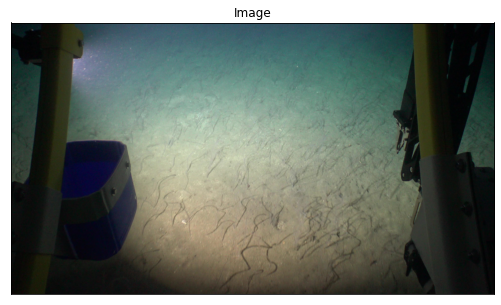

In [6]:
# Show an image from the training test
temp_dataset = Dataset(train_dir)

image, label = temp_dataset[2]
print(label)
visualize(
    image=image, 
)

Se definen las augmentations que solo tendrán lugar durante el entrenamiento

In [7]:
transforms = Compose([
            Blur(),
            RandomBrightnessContrast(brightness_limit=0.6, contrast_limit=0.6),
            ImageCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            Affine(translate_percent=0.1, shear=[-25, 25]),
            Perspective()
        ])

Inicialización de los dataloaders

In [8]:
train_dataset = Dataset(train_dir, augmentation=transforms)
val_dataset = Dataset(val_dir)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=1, shuffle=False)

Definición de la capa para recortar el tercio central de la imagen

In [9]:
class Crop(tf.keras.layers.Layer):
    def __init__(self, name=None, trainable=None, dtype=None):
        super(Crop, self).__init__()
        width_proportion = 0.67
        self.p = tf.constant(width_proportion, dtype=tf.float32)

    def call(self, inputs):
        shape = tf.shape(inputs)
        
        i_shape = shape[-2]
        i_shape_f = tf.cast(i_shape, dtype=tf.float32)
        ran = tf.cast(tf.round((i_shape_f * self.p) / 2), dtype=tf.int32)
        low = i_shape // 2 - ran
        hight = i_shape // 2 + ran
        
        return inputs[:, :, low:hight, :]

Parametrización del entrenamiento

In [10]:
# shape of the raw images
og_shape = (2160, 3840, 3)
# shape of the input of the network
input_shape = (512, 512, 3)
# epochs
epochs_top_layers = 7
epochs_fine_tuning = 5
# class ponderation
class_weights = {0: 1.,
                1: 2.38,
                2: 3.74,
                3: 2.5,
                4: 5.71}
# normalization
scale_layer = preprocessing.Rescaling(scale=1 / 127.5, offset=-1)
# second augmentation
train_aug = keras.models.Sequential([
    Crop(),
    preprocessing.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    preprocessing.RandomRotation(0.05),
    preprocessing.Resizing(input_shape[0], input_shape[1]),
    preprocessing.RandomFlip("horizontal"),
])
# callbacks
callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
]

#### Transfer learning y fine-tuning

In [12]:
# Load model
base_model = keras.applications.ResNet152V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=input_shape,
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze base
base_model.trainable = False

# Add layers on top
inputs = keras.Input(shape=(None, None, 3))  # Trivial size input
x = train_aug(inputs)
x = scale_layer(x)
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(5)(x)
model = keras.Model(inputs, outputs)

# Compile and fit last layers
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()], weighted_metrics=['accuracy'])
model.fit(train_dataloader, epochs=epochs_top_layers, callbacks=callbacks, validation_data=val_dataloader, class_weight=class_weights)

# Fine-tuning
base_model.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()], weighted_metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(train_dataloader, epochs=epochs_fine_tuning, callbacks=callbacks, validation_data=val_dataloader, class_weight=class_weights)

Epoch 1/7
620/620 [==============================] - 548s 876ms/step - loss: 2.1455 - categorical_accuracy: 0.6379 - accuracy: 0.6348 - val_loss: 0.6068 - val_categorical_accuracy: 0.7470 - val_accuracy: 0.7470


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/7
620/620 [==============================] - 538s 869ms/step - loss: 1.2512 - categorical_accuracy: 0.7931 - accuracy: 0.8087 - val_loss: 0.5001 - val_categorical_accuracy: 0.8193 - val_accuracy: 0.8193
Epoch 3/7
620/620 [==============================] - 530s 855ms/step - loss: 1.1488 - categorical_accuracy: 0.8113 - accuracy: 0.8172 - val_loss: 0.2705 - val_categorical_accuracy: 0.9458 - val_accuracy: 0.9458
Epoch 4/7
620/620 [==============================] - 532s 857ms/step - loss: 0.9528 - categorical_accuracy: 0.8448 - accuracy: 0.8569 - val_loss: 0.2993 - val_categorical_accuracy: 0.9237 - val_accuracy: 0.9237
Epoch 5/7
620/620 [==============================] - 536s 864ms/step - loss: 0.8569 - categorical_accuracy: 0.8528 - accuracy: 0.8680 - val_loss: 0.2745 - val_categorical_accuracy: 0.9116 - val_accuracy: 0.9116
Epoch 6/7
620/620 [==============================] - 534s 860ms/step - loss: 0.8712 - categorical_accuracy: 0.8657 - accuracy: 0.8683 - val_loss: 0.2148 - v